In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from fitter import Fitter
from scipy.stats import pearsonr, spearmanr
import statsmodels.api as sm
import statsmodels.formula.api as smf

import xgboost as xgb
import lightgbm as lgb

from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, StandardScaler
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.linear_model import Lasso, RidgeCV, LinearRegression
from sklearn.ensemble import RandomForestRegressor, StackingRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.base import BaseEstimator, TransformerMixin
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

plt.style.use('bmh')

/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv
/kaggle/input/house-prices-advanced-regression-techniques/data_description.txt
/kaggle/input/house-prices-advanced-regression-techniques/train.csv
/kaggle/input/house-prices-advanced-regression-techniques/test.csv


# Introduction

Welcome to my Kaggle notebook, where we will embark on an exciting journey through the world of modeling the Ames Iowa housing dataset. Our mission? To predict house prices with astonishing accuracy using the power of Statistics and Machine Learning. Spoiler alert: this adventure led to a remarkable top 2% submission on the test dataset!

Buckle up as we delve deep into the data, uncovering insights, and crafting models that fit just right. But wait, there's more! Along the way, we'll sprinkle in some fascinating tidbits and techniques that will leave you itching to apply them to your own projects.

Here's a sneak peek of what lies ahead:


### Basic EDA
* Unraveling the Mysteries of Data Types
* Taming the Beast: Handling Null Values
* Plotting Correlations Across Categorical And Continuous Variables: A Dizzying Array of Color and Insight

### Advanced EDA
* Peering Into the Future: Using Linear Regression To Reveal the Central A/C Effect on House Prices
* Unlocking Neighborhood Secrets: Leveraging Linear Mixed Effects Modeling to Understand Price-Square Footage Dynamics

### Model Development
* Crafting the Perfect Ensemble: Hyperparameter Tuning a Light Gradient Boosted Machine model with GridSearchCV
* Riding the Waves: Hyperparameter Tuning an eXtreme Gradient Boosted model with GridSearchCV
* Fine-Tuning to Perfection: Hyperparameter Tuning a Lasso Regression model with GridSearchCV
* Reaching for the Stars: Building a StackingRegressor Pipeline
* Lights, Camera, Action: Evaluating Model Performance

Sit back, relax, and enjoy the ride. Don't hesitate to drop a comment on anything that catches your eye. Let's dive in! 🚀

In [2]:
df = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/train.csv')
df_test = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/test.csv')

In [3]:
df = df.assign(LogSalePrice = np.log(df['SalePrice']))

# Functions
* Here are a few functions that will help us slice and dice our dataset

In [4]:
def plot_distribution_across_category(data, category_col, numeric_col, jitter=True, title=''):
    """
    Plot data distribution across a categorical variable using both strip plot and violin plot.

    Args:
        data (DataFrame): Pandas DataFrame containing the data.
        category_col (str): Name of the column in `data` to be treated as categorical variable.
        numeric_col (str): Name of the column in `data` that contains numeric values.
        jitter (bool): If True, adds jitter to the strip plot to make it easier to see individual data points.

    Returns:
        Matplotlib axis object: Returns the Matplotlib axis object for further manipulation if necessary.

    """
    
    title = f'Distribution of {numeric_col} Across {category_col}' if not title else title
    rotation = 45 if df[category_col].nunique() > 5 else 0
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=FutureWarning)
        plt.figure(figsize=(18, 4))
        sns.violinplot(x=category_col, y=numeric_col, data=data, inner=None, color="0.8" )
        sns.stripplot(x=category_col, y=numeric_col, data=data, jitter=jitter, alpha=0.5)
        plt.title(title)
        plt.xlabel(category_col)
        plt.ylabel(numeric_col)
        plt.xticks(rotation=rotation)
        plt.tight_layout()
    return plt.gca()


def plot_scatter_with_correlations(df, x, y, hue=None, title = ''):
    """
    Creates a scatterplot with Pearson and Spearman correlation coefficients displayed for the overall dataset,
    regardless of any hue categorization.
    
    Args:
        data (pd.DataFrame): DataFrame containing the data to plot.
        x (str): Name of the column to use as x-values in the plot.
        y (str): Name of the column to use as y-values in the plot.
        hue (str, optional): Name of the column to use for color encoding. Default is None.
    
    Returns:
        matplotlib.axes.Axes: The Axes object with the plot.
    """
    df = df.copy()
    if hue:
        df[hue] = df[hue].astype('category')
    plt.figure(figsize=(10, 10))
    title = f' {y} on {x} by {hue}' if not title else title
    ax = sns.scatterplot(data=df, x=x, y=y, hue=hue)
    plt.title(title)
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=FutureWarning)
        x_data = df[x].dropna()
        y_data = df[y].dropna()

        pearson_corr, _ = pearsonr(x_data, y_data)
        spearman_corr, _ = spearmanr(x_data, y_data)
        ax.text(0.05, 0.95, f'Pearson: {pearson_corr:.2f}', transform=ax.transAxes, fontsize=12, verticalalignment='top')
        ax.text(0.05, 0.90, f'Spearman: {spearman_corr:.2f}', transform=ax.transAxes, fontsize=12, verticalalignment='top')
        plt.legend(title=hue, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
        plt.tight_layout()
    return ax

def plot_missing_values(df):
    """
    Plots the number of missing values for each column containing NaN values in the given DataFrame.

    Parameters:
    df (pd.DataFrame): The DataFrame to analyze.

    Returns:
    None: Displays a bar plot of the missing values.
    """
    # Count missing values in each column
    missing_values = df.isna().sum().sort_values(ascending = False)

    # Filter only columns with missing values
    missing_values = missing_values[missing_values > 0]

    if missing_values.empty:
        print("No missing values found.")
        return

    plt.figure(figsize=(14, 6))
    missing_values.plot(kind='bar', color='skyblue')
    plt.title('Number of Missing Values per Column')
    plt.xlabel('Columns')
    plt.ylabel('Number of Missing Values')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# EDA

* Here we will explore what data types we are dealing with.

In [5]:
df.dtypes.value_counts()

object     43
int64      35
float64     4
Name: count, dtype: int64

In [6]:
object_mask = df.dtypes == 'object'
int_64_mask = df.dtypes == 'int64'
float_64_mask = df.dtypes == 'float64'

### Columns By Data Type


In [7]:
print(df.dtypes[object_mask].index)
print(f"{np.sum(object_mask)} Int Cols")

Index(['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
       'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature',
       'SaleType', 'SaleCondition'],
      dtype='object')
43 Int Cols


In [8]:
print(df.dtypes[int_64_mask].index)
print(f"{np.sum(int_64_mask)} Int Cols")

Index(['Id', 'MSSubClass', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF',
       'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea',
       'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr',
       'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageCars',
       'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch',
       'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold', 'SalePrice'],
      dtype='object')
35 Int Cols


In [9]:
print(df.dtypes[float_64_mask].index)
print(f"{np.sum(float_64_mask)} Int Cols")

Index(['LotFrontage', 'MasVnrArea', 'GarageYrBlt', 'LogSalePrice'], dtype='object')
4 Int Cols


### Missing Values By Column Training Data
* Lets take a look at which columns have missing values in our Train and Test datasets

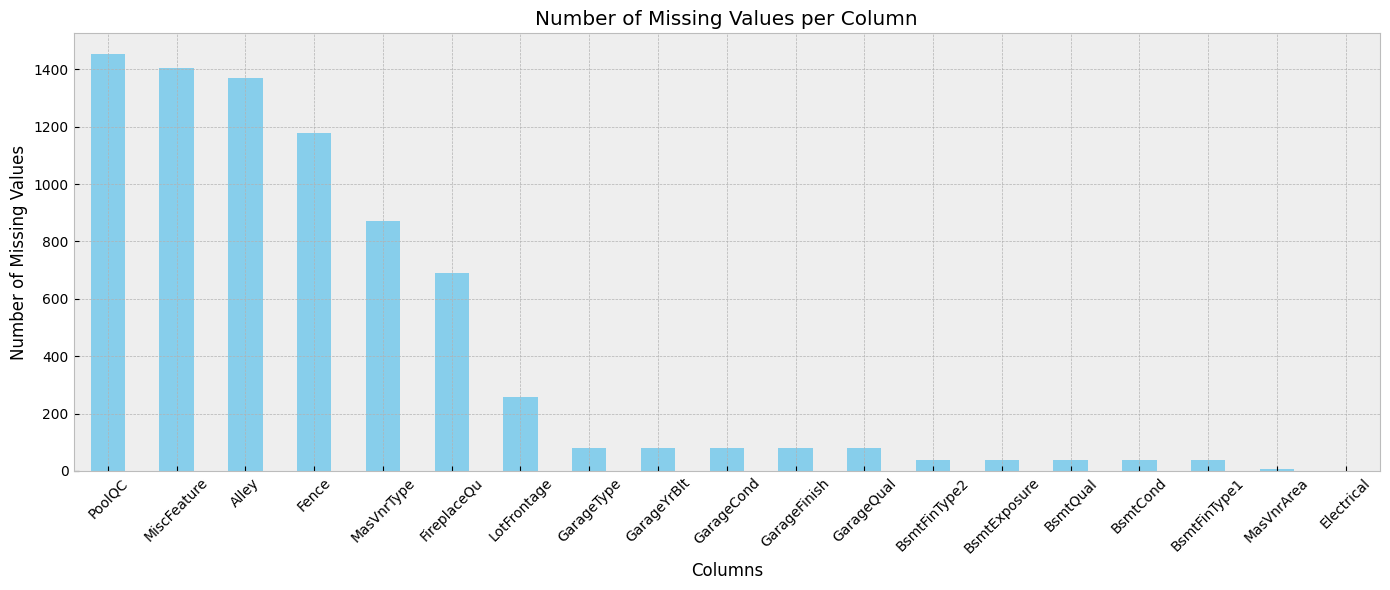

In [10]:
plot_missing_values(df)

### Missing Values By Column Test Data

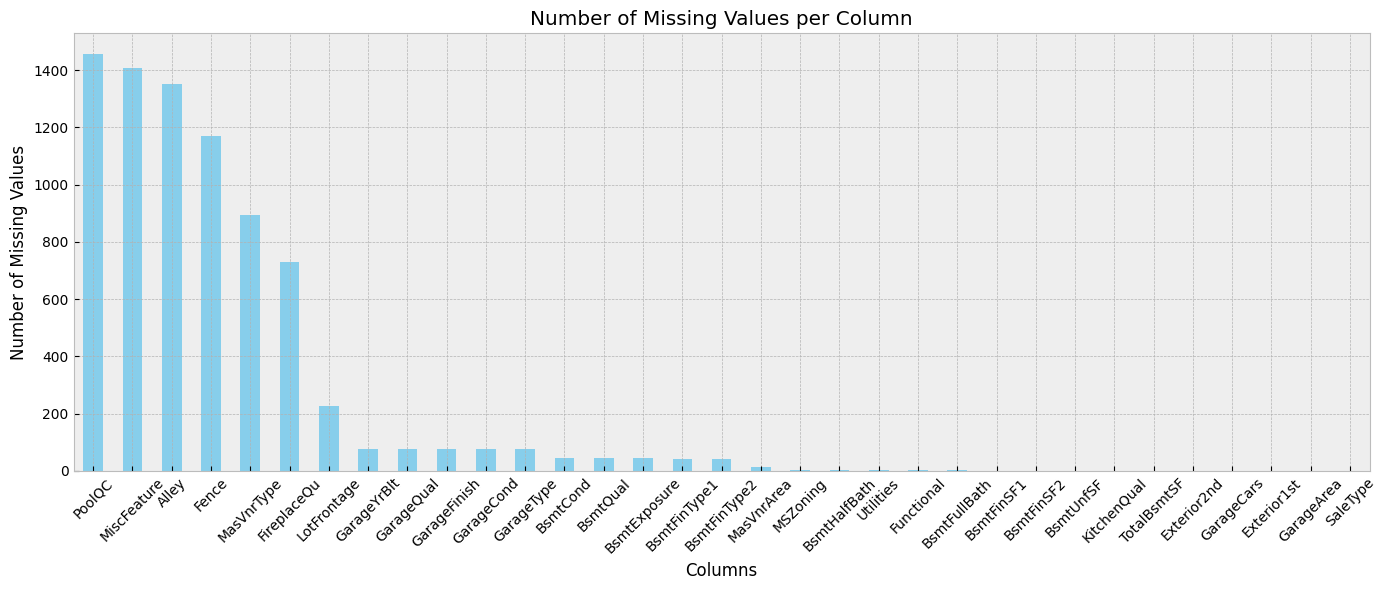

In [11]:
plot_missing_values(df_test)

### Handle Missing Values   
**After looking at the structure of the missing data across each variable, I decided to implore the following strategy on the training and test dataset.**
* PoolQC -> Remove
* MiscFeature -> Create Shed Var
* Alley -> Fill NA with None Category
* Fence -> Fill NA with None Category
* MasVnrType -> Fill NA with None
* FireplaceQu -> Fill NA with None
* LotFrontage -> Fill with Neighborhood mean
* GarageYrBlt -> Fill NA wth Average
* GarageQual -> Fill NA with None
* GarageCond -> Fill NA with None
* GarageFinish -> Fill NA with None
* BsmtExposure -> Fill NA with None
* BsmtFinType2 -> Fill NA with None
* BsmtQual -> Fill NA with None
* BsmtCond -> Fill NA with None
* BsmtFinType1 -> Fill NA with None
* MasVnrArea -> Fill NA with 0
* Electrical -> Fill NA with Unknown

In [12]:
# Calculate Total Baths
df['TotalBath'] = df['FullBath'] + df['HalfBath']*0.5 + df['BsmtFullBath'] + df['BsmtHalfBath'] * 0.5

# Calculate Years Since Remodel
df['YearsSinceRemod'] = df['YrSold'] - df['YearRemodAdd']

# Calculate Total SF
df['TotalSF']  = df['TotalBsmtSF'] + df['GrLivArea']

# Calculate Total SF * Lot Area
df['TotalSFXLotArea'] = df['TotalSF'] * df['LotArea']

# Calculate House Per Lot Area
df['HousePerLotArea'] = df['TotalSF']/df['LotArea']

# Calculate SFPerRoom
df['SFPerRoom'] = (df['GrLivArea'])/df['TotRmsAbvGrd']

# Calculate Log Total SF
df['LogTotalSF'] = np.log(df['TotalSF'])

# Calculate Log Lot Area
df['LogLotArea'] = np.log(df['LotArea'])

# Fill Na with Average for Neighborhood
df['LotFrontage'] = (df
                    .merge(df.groupby('Neighborhood').agg(Average_lot = ('LotFrontage','mean')),on = 'Neighborhood',how = 'left' )
                    .assign(LotFrontage = lambda df: df['LotFrontage'].fillna(df['Average_lot'])))['LotFrontage']

# Calculate Log Lot Frontage
df['LogLotFrontage'] = np.log(df['LotFrontage'])

# Fill Garage Type
df['GarageType'] = df['GarageType'].fillna('None')

# Log BsmtFinSF1
df['LogBsmtFinSF1'] = np.log(df['BsmtFinSF1'] + 1)

# Log BsmtFinSF1
df['LogBsmtFinSF2'] = np.log(df['BsmtFinSF2'] + 1)

# Log BsmtUnfSF
df['LogBsmtUnfSF'] = np.log(df['BsmtUnfSF'] + 1)

# Log BsmtUnfSF
df['LogTotalBsmtSF'] = np.log(df['TotalBsmtSF'] + 1)

# Shed Indicator
df['Shed'] = (df['MiscFeature'] == 'Shed').astype(int)

# Fill Alley NA with None
df['Alley'] = df['Alley'].fillna('None')

# Fill Fence NA with None
df['Fence'] = df['Fence'].fillna('None')

# Fill MasVnrType
df['MasVnrType'] = df['MasVnrType'].fillna('None')

# Fill NA with None
df['FireplaceQu'] = df['FireplaceQu'].fillna('None')

# Fill NA with Mean
df['GarageYrBlt'] = df['GarageYrBlt'].fillna(df['GarageYrBlt'].mean())

# Fill NA with None
df['GarageFinish'] = df['GarageFinish'].fillna('None')

# Fill NA with None
df['GarageQual'] = df['GarageQual'].fillna('None')

# Fill NA with None
df['GarageCond'] = df['GarageCond'].fillna('None')

# Fill NA with None
df['BsmtExposure'] = df['BsmtExposure'].fillna('None')

# Fill NA with None
df['BsmtFinType2'] = df['BsmtFinType2'].fillna('None')

# Fill NA with None
df['BsmtQual'] = df['BsmtQual'].fillna('None')

# Fill NA with None
df['BsmtCond'] = df['BsmtCond'].fillna('None')

# Fill NA with None
df['BsmtFinType1'] = df['BsmtFinType1'].fillna('None')

# Fill NA with None
df['Electrical'] = df['Electrical'].fillna('Unknown')

# Fill NA With 0
df['MasVnrArea'] = df['MasVnrArea'].fillna(0)

columns_to_log = ['WoodDeckSF', 'OpenPorchSF', '1stFlrSF', '2ndFlrSF', 'MasVnrArea','LowQualFinSF','GrLivArea','GarageArea','PoolArea']
for col in columns_to_log:
    df[f'Log{col}'] = np.log(df[col] + 1)
    
df = df.drop(['PoolQC','MiscFeature'] , axis = 1).copy()

In [13]:
# Fill NA with Lot Frontage For Neighborhood
df_test['LotFrontage'] = (df_test
                    .merge(df_test.groupby('Neighborhood').agg(Average_lot = ('LotFrontage','mean')),on = 'Neighborhood',how = 'left' )
                    .assign(LotFrontage = lambda df: df['LotFrontage'].fillna(df['Average_lot'])))['LotFrontage']


# Calculate Total Baths
df_test['TotalBath'] = df_test['FullBath'] + df_test['HalfBath']*0.5 + df_test['BsmtFullBath'] + df_test['BsmtHalfBath'] * 0.5

# Calculate Years Since Remodel
df_test['YearsSinceRemod'] = df_test['YrSold'] - df_test['YearRemodAdd']

# Calculate Total SF
df_test['TotalSF']  = df_test['TotalBsmtSF'] + df_test['GrLivArea']

# Calculate Total SF * Lot Area
df_test['TotalSFXLotArea'] = df_test['TotalSF'] * df_test['LotArea']

# Calculate House Per Lot Area
df_test['HousePerLotArea'] = df_test['TotalSF'] / df_test['LotArea']

# Calculate SFPerRoom
df_test['SFPerRoom'] = df_test['GrLivArea'] / df_test['TotRmsAbvGrd']

# Calculate Log Total SF
df_test['LogTotalSF'] = np.log(df_test['TotalSF'])

# Calculate Log Lot Area
df_test['LogLotArea'] = np.log(df_test['LotArea'])

# Calculate Total SF X Lot Area
df_test['LogTotalSFXLotArea'] = np.log(df_test['TotalSFXLotArea'])

# Fill Garage Type
df_test['GarageType'] = df_test['GarageType'].fillna('None')

# Log Lot Frontage
df_test['LogLotFrontage'] = np.log(df_test['LotFrontage'])

# # Log BsmtFinSF1
df_test['LogBsmtFinSF1'] = np.log(df_test['BsmtFinSF1'] + 1)

# # Log BsmtFinSF2
df_test['LogBsmtFinSF2'] = np.log(df_test['BsmtFinSF2'] + 1)

# Log 
df_test['LogBsmtUnfSF'] = np.log(df_test['BsmtUnfSF'] + 1)

# Log
df_test['LogTotalBsmtSF'] = np.log(df_test['TotalBsmtSF'] + 1)

# Create Shed Indicator
df_test['Shed'] = (df_test['MiscFeature'] == 'Shed').astype(int)

# Fill NA with None
df_test['Alley'] = df_test['Alley'].fillna('None')

# Fill NA with None
df_test['Fence'] = df_test['Fence'].fillna('None')

# Fill NA with None 
df_test['MasVnrType'] = df_test['MasVnrType'].fillna('None')

# Fill NA with None
df_test['FireplaceQu'] = df_test['FireplaceQu'].fillna('None')

# Fill NA with MEan
df_test['GarageYrBlt'] = df_test['GarageYrBlt'].fillna(df['GarageYrBlt'].mean())

# Fill NA with None
df_test['GarageFinish'] = df_test['GarageFinish'].fillna('None')

# Fill NA with None
df_test['GarageQual'] = df_test['GarageQual'].fillna('None')

# Fill NA with None
df_test['GarageCond'] = df_test['GarageCond'].fillna('None')

# Fill NA with None
df_test['BsmtExposure'] = df_test['BsmtExposure'].fillna('None')

# Fill NA with None
df_test['BsmtFinType2'] = df_test['BsmtFinType2'].fillna('None')

# Fill NA with None
df_test['BsmtQual'] = df_test['BsmtQual'].fillna('None')

# Fill NA with None
df_test['BsmtCond'] = df_test['BsmtCond'].fillna('None')

# Fill NA with None
df_test['BsmtFinType1'] = df_test['BsmtFinType1'].fillna('None')

# Fill NA with None
df_test['Electrical'] = df_test['Electrical'].fillna('Unknown')

# Fill NA With 0
df_test['MasVnrArea'] = df_test['MasVnrArea'].fillna(0)


for col in columns_to_log:
    df_test[f'Log{col}'] = np.log(df_test[col] + 1)
    
df_test = df_test.drop(['PoolQC','MiscFeature'] , axis = 1).copy()

### Missing Values After Cleanup Training

In [14]:
plot_missing_values(df)

No missing values found.


### Plot Missing Values After Cleanup Test

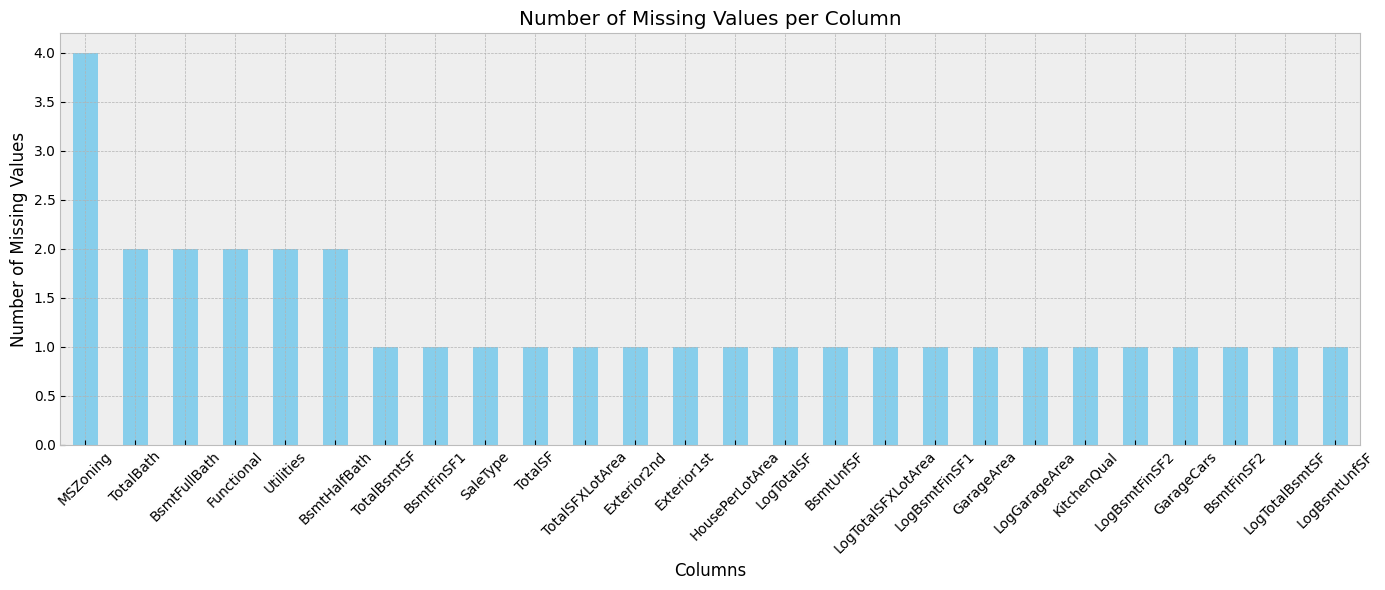

In [15]:
plot_missing_values(df_test)

### Distribution of Home Prices   

After cleaning the data, for a regression problem I always like to take a look at the distribution of the target variable. Here we can see the Log of the SalePrice variable looks to be unimodal with a slightly right skew.

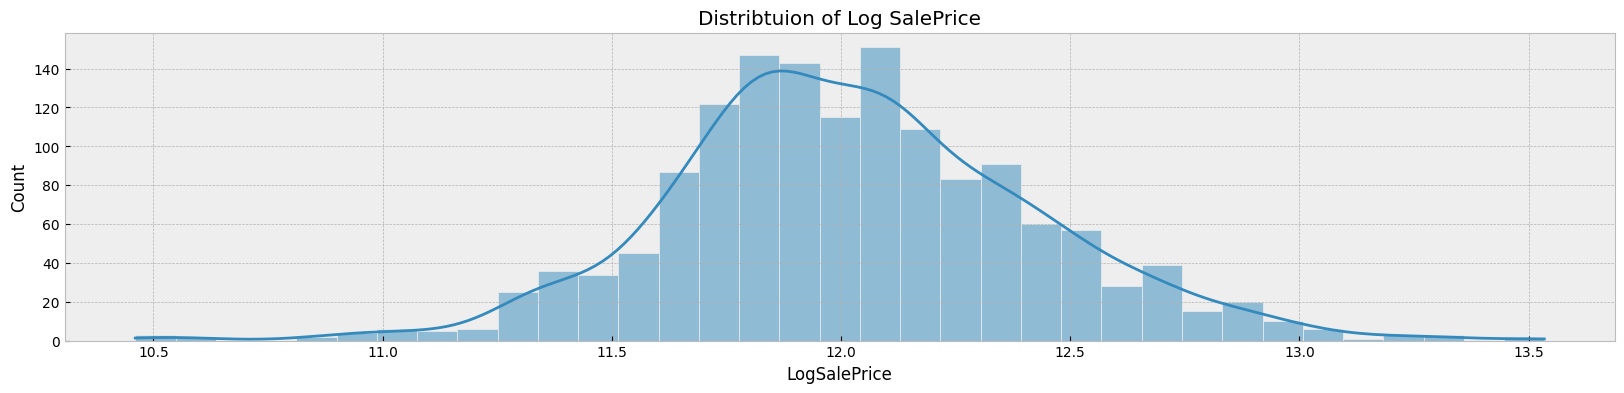

In [16]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=FutureWarning)
    plt.figure(figsize = (20,4))
    sns.histplot(df['LogSalePrice'],kde = True)
    plt.title('Distribtuion of Log SalePrice')

### Fit Best Distribution With Fitter On Log Of SalePrice

Here I am going to use the Fitter library to see what are the best known distributions that fit our target variable. This is a good way to determine if the right transformation (in this case, taking the log of house price) was applied

In [17]:
f = Fitter(np.log(df['SalePrice']))
f.fit()

2024-05-13 19:27:04.055 | WARNING  | fitter.fitter:_fit_single_distribution:347 - SKIPPED _fit distribution (taking more than 30 seconds)
2024-05-13 19:27:04.249 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted anglit distribution with error=8.171216)
2024-05-13 19:27:04.771 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted arcsine distribution with error=25.438473)
2024-05-13 19:27:04.810 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted argus distribution with error=11.739495)
2024-05-13 19:27:04.928 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted alpha distribution with error=1.558692)
2024-05-13 19:27:05.415 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted beta distribution with error=1.598992)
2024-05-13 19:27:05.466 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted bradford distribution with error=15.374544)
2024-05-13 19:27:05.544 | INFO     | fitter.fitter:_fit_single_distribution:337 

,sumsquare_error,aic,bic,kl_div,ks_statistic,ks_pvalue
genhyperbolic,1.264595,462.111378,488.542337,inf,0.025639,0.287552
dweibull,1.276311,446.920542,462.779117,inf,0.033109,0.079638
dgamma,1.300975,434.620497,450.479072,inf,0.038214,0.027403
norminvgauss,1.322237,460.116570,481.261337,inf,0.028349,0.187619
johnsonsu,1.324698,460.702138,481.846904,inf,0.028483,0.183470


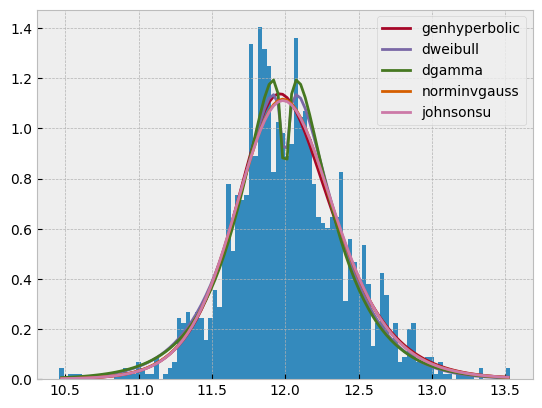

In [18]:
f.summary()

### Spearman and Pearson Corr Matrix

Now let's step into the world beyond univariate analysis! Here we dive into the data relationships with both the Spearman and Pearson Correlation Matrices across continuous variables.

Why both, you ask? Well, it's all about gaining insights into the linearity of relationships between our continuous features and the logarithm of sales price. The Spearman correlation, being a rank correlation, offers a different perspective compared to the Pearson correlation. If they diverge, it could hint at the presence of nonlinear relationships between our predictor and response.

For instance, take the correlation between LogSalePrice and LotArea. Pearson gives us a moderate correlation of 0.39, but Spearman steps in with a stronger 0.51, hinting at a nonlinear dance between the variables.

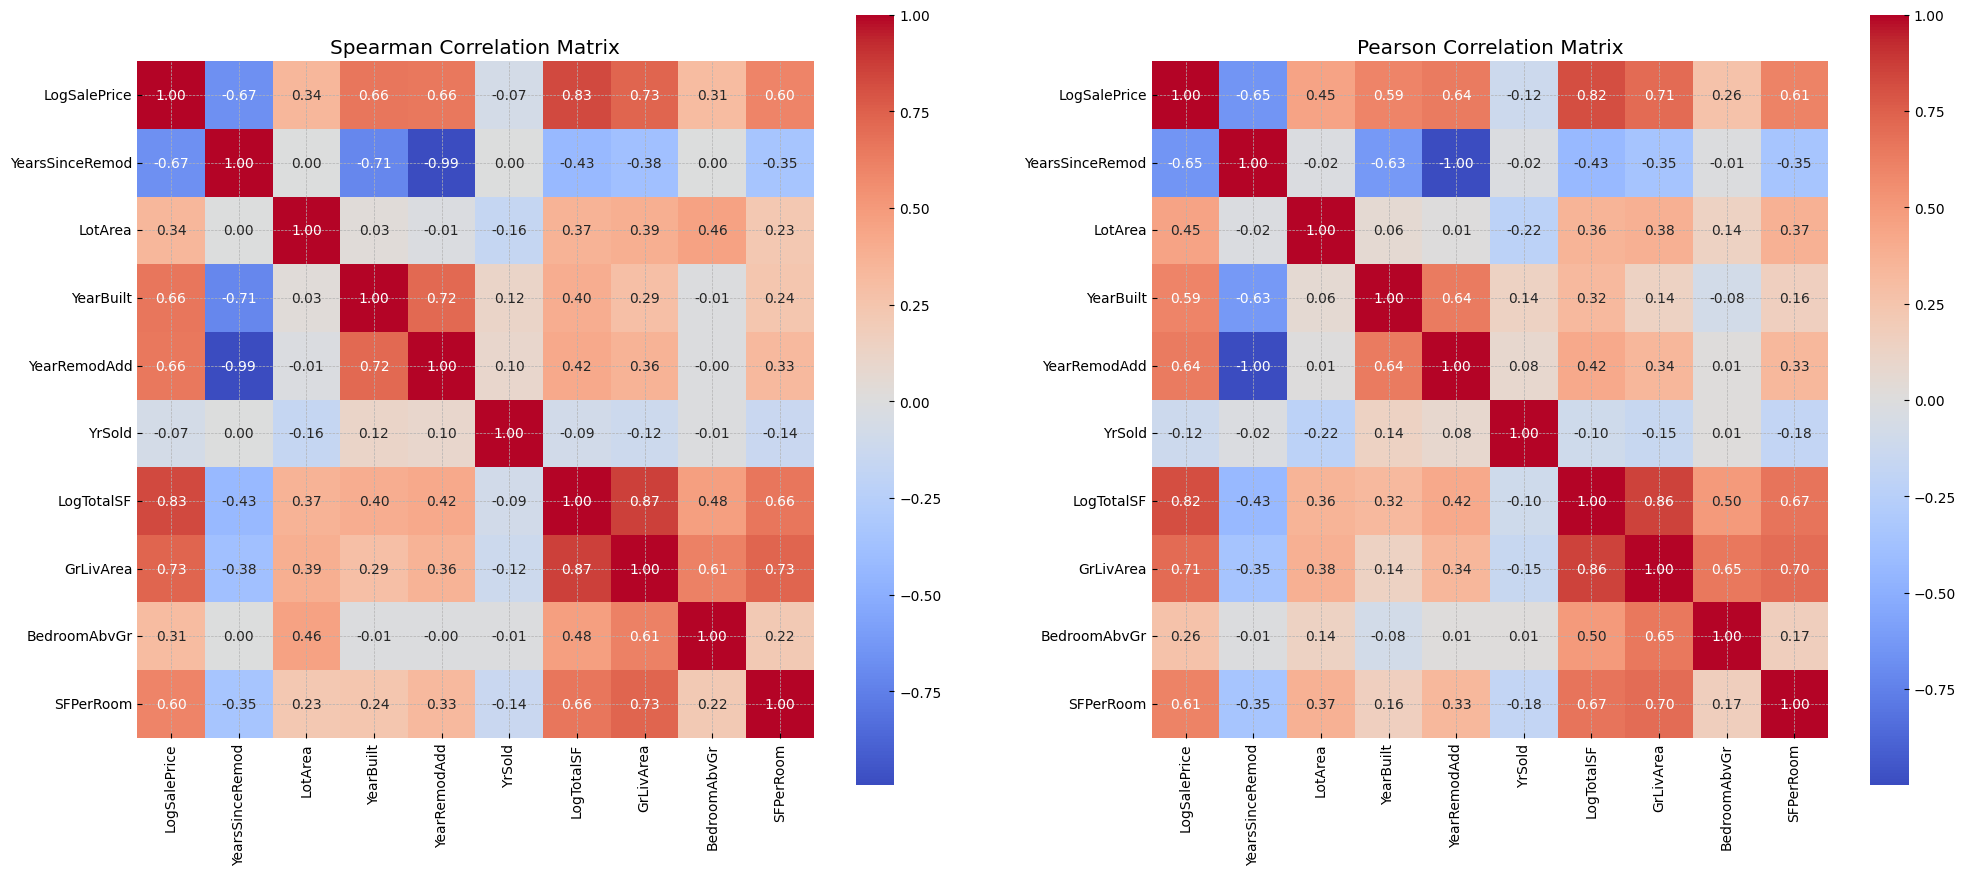

In [19]:
corr_col_list = [
                'LogSalePrice',
                 'YearsSinceRemod',
                 'LotArea',
                 'YearBuilt',
                 'YearRemodAdd',
                 'YrSold',
                 'LogTotalSF',
                 'GrLivArea',
                 'BedroomAbvGr',
                  'SFPerRoom'
                ]
df_sample_pre_corr= df[corr_col_list].sample(150).copy()
spearman_corr_matrix = df_sample_pre_corr.corr(method = 'spearman')
pearson_corr_matrix = df_sample_pre_corr.corr(method = 'pearson')

plt.figure(figsize=(24, 10))


plt.subplot(1, 2, 1)  
sns.heatmap(spearman_corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True, square=True)
plt.title('Spearman Correlation Matrix')


plt.subplot(1, 2, 2) 
sns.heatmap(pearson_corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True, square=True)
plt.title('Pearson Correlation Matrix')
plt.show()

### Distribution of House Price Across Categories   

Remember earlier in the notebook when we invested time in crafting some nifty plotting functions? Well, that upfront development time is about to pay dividends as we embark on a quest to visualize our response variable across some categorical variables. Get ready to uncover features that pack predictive punch!

Here we can see some clear discrepencies in price across the different neighborhoods   
For example, Northridge Heights and Stoney Brook seem to have home prices on the High End of the price distribution whereas, Sawyer is on the lower end

<Axes: title={'center': 'Log Sales Price On Neighborhood'}, xlabel='Neighborhood', ylabel='LogSalePrice'>

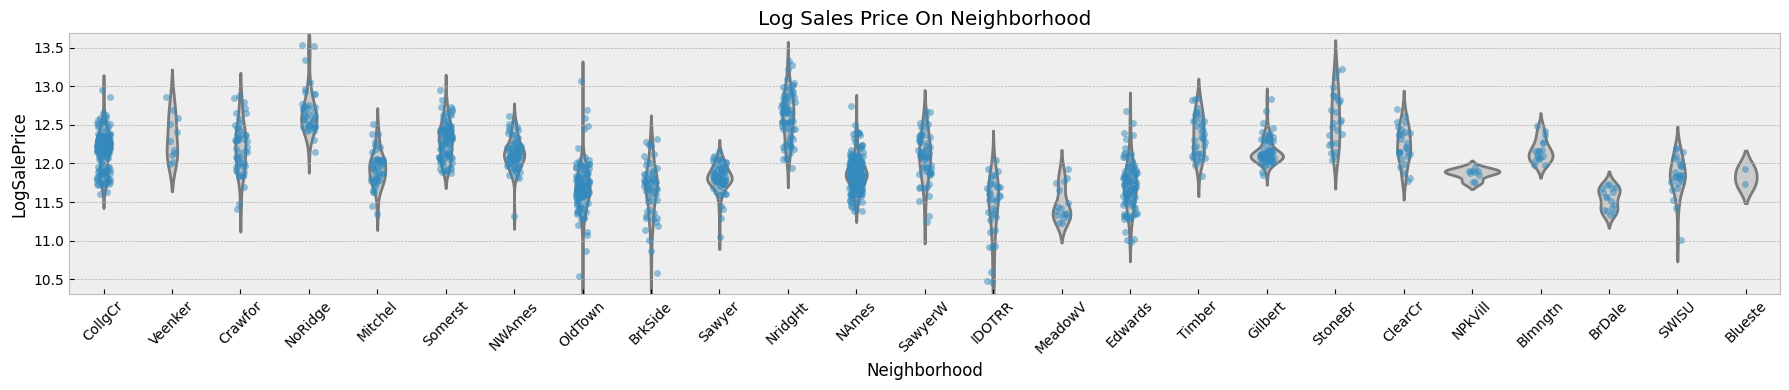

In [20]:
plot_distribution_across_category(df,'Neighborhood','LogSalePrice',True, 'Log Sales Price On Neighborhood')

Here, as expected we see that the sale price of the house increases in step with the Overall Quality.

<Axes: title={'center': 'Log Sale Price On Overall Quality'}, xlabel='OverallQual', ylabel='LogSalePrice'>

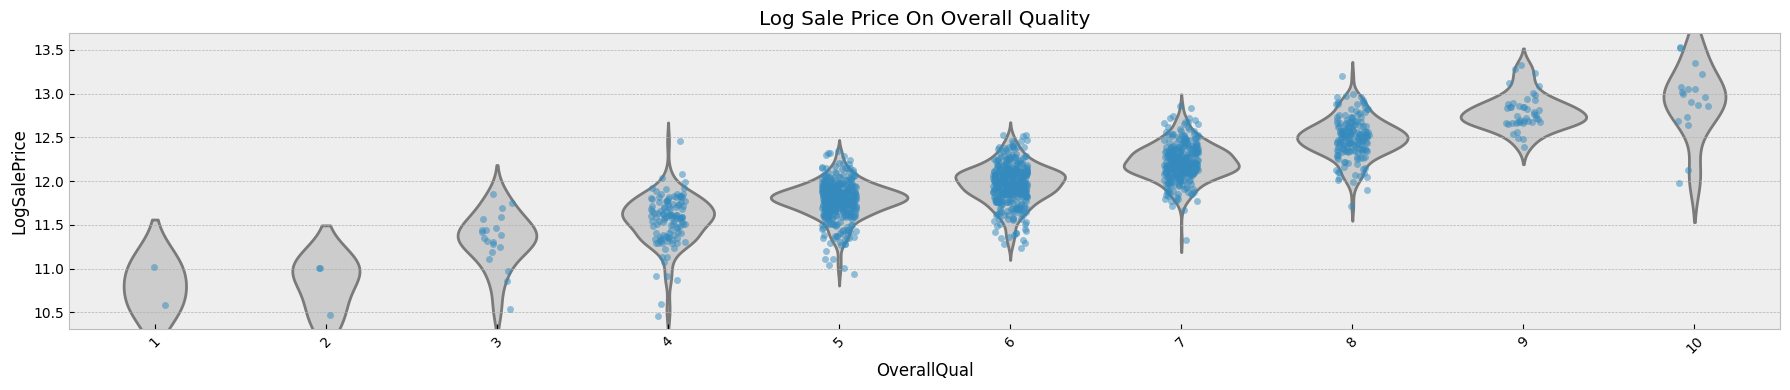

In [21]:
plot_distribution_across_category(df,'OverallQual','LogSalePrice', True, 'Log Sale Price On Overall Quality')

### House Price as A Function of Total Square Feet Colored By Category

Thanks to our handy plotting functions developed earlier, we're diving deeper into understanding the relationships between predictors and our response variable.

This time, we're examining how the logarithm of sale price changes with the logarithm of total square footage. But wait, there's more! We're adding a splash of color to our data points, first by the overall quality ranking, and then by total baths.

The results? Well, they're not exactly shocking. As expected, the logarithm of sale price shows a positive linear correlation with the logarithm of total square footage. The colors also reveal that the overall quality of the house is correlated with both the logarithm of sale price and total square footage.

In Figure 2, we observe that sales price increases with the number of total bathrooms up to a certain point. Houses with 4.5 total baths, situated at the center of the distribution of both sale price and square footage, demonstrate this trend. It's logical to assume that larger houses necessitate more bathrooms. However, the impact of having more than 3 bathrooms on the house price seems negligible, which aligns with expectations.

<Axes: title={'center': ' LogSalePrice on LogTotalSF by OverallQual'}, xlabel='LogTotalSF', ylabel='LogSalePrice'>

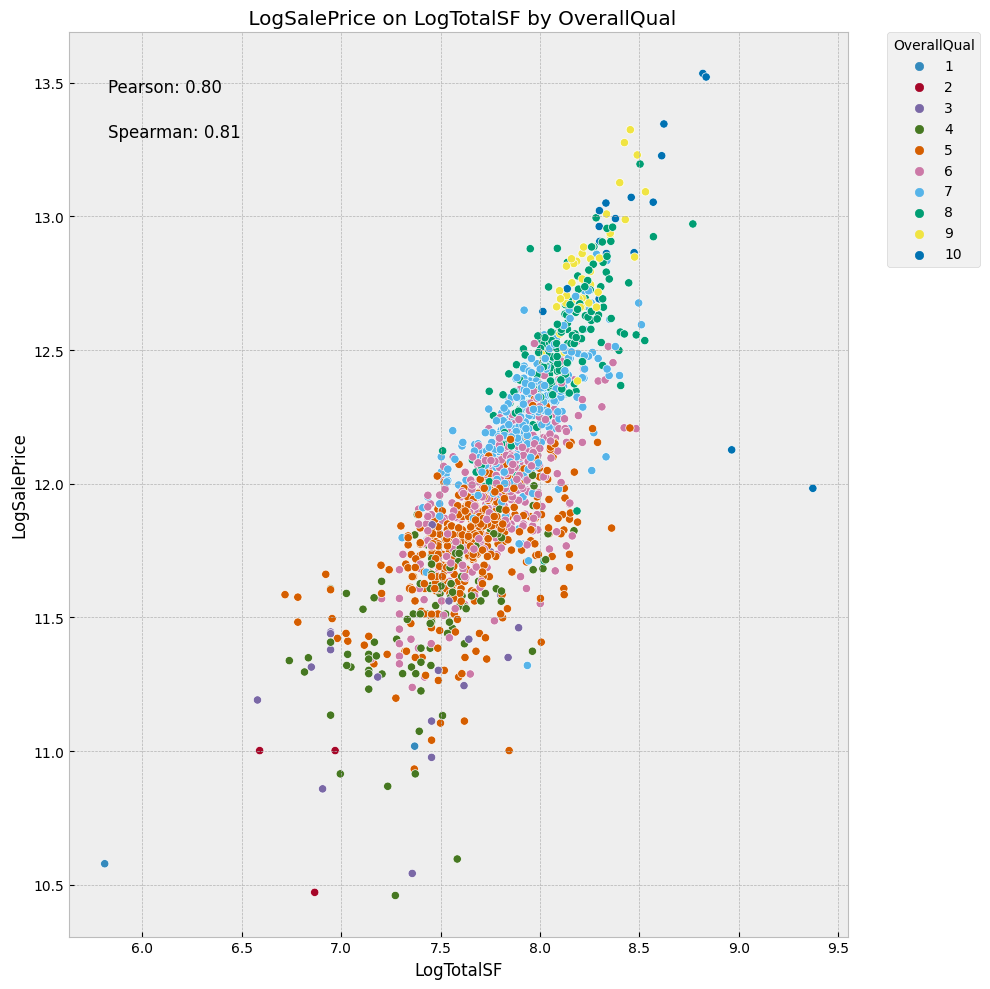

In [22]:
plot_scatter_with_correlations(df,'LogTotalSF','LogSalePrice',hue = 'OverallQual')

<Axes: title={'center': ' LogSalePrice on LogTotalSF by TotalBath'}, xlabel='LogTotalSF', ylabel='LogSalePrice'>

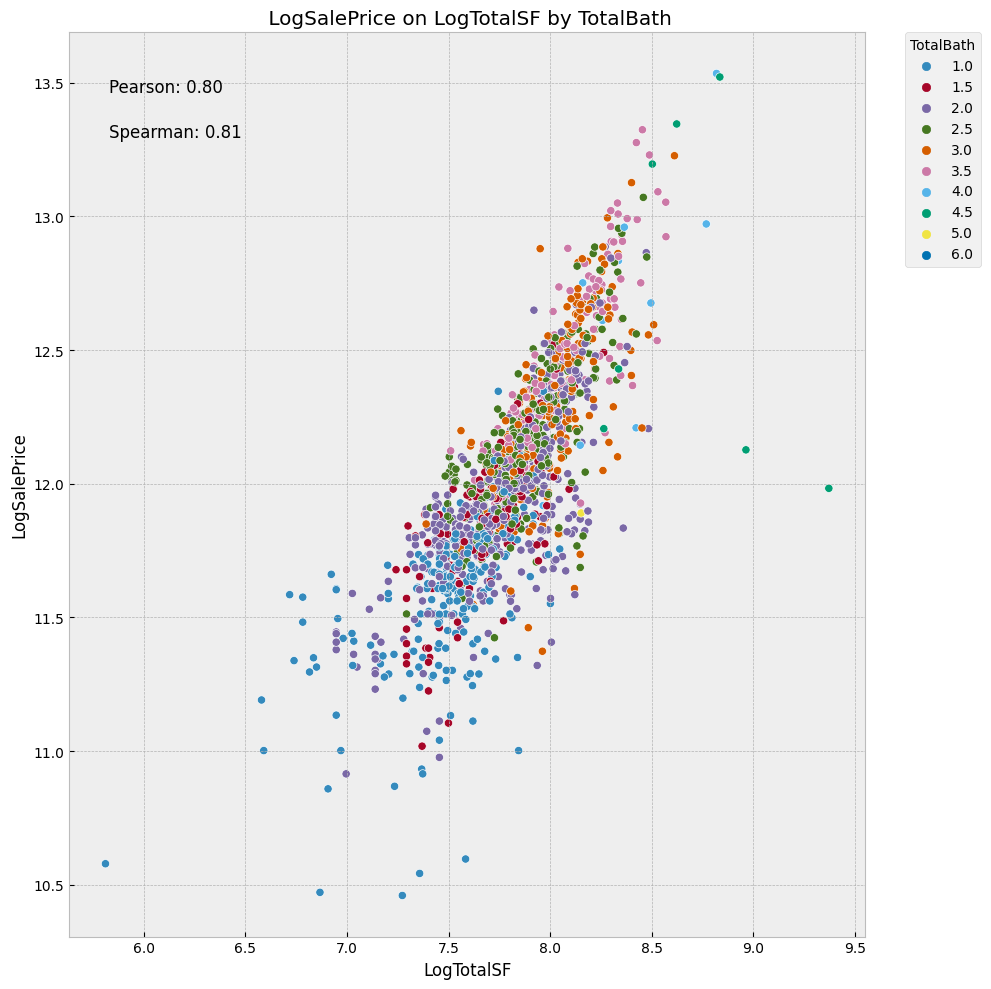

In [23]:
plot_scatter_with_correlations(df,'LogTotalSF','LogSalePrice',hue = 'TotalBath')

# Advanced EDA

### Linear Regression and The A/C effect

After filtering for the lowest housing prices and employing Seaborn's ```lmplot``` function, a distinct shift becomes evident in the LogSalePrice concerning LogTotalSF. This shift seems consistent across the entire spectrum of total square footage. Essentially, the plot implies that the linear trend LogSalePrice follows in relation to the LogTotalSF of the house remains similar regardless of whether the house has Central Air. However, houses with Central Air seem to command a constant premium.

In a Linear Regression model depicting the relationship between LogSalePrice and LogTotalSF, introducing an indicator for the Central Air variable would alter the intercept of the line equation. Let's delve into this by fitting a linear regression model of LogSalePrice on LogTotalSF and CentralAir

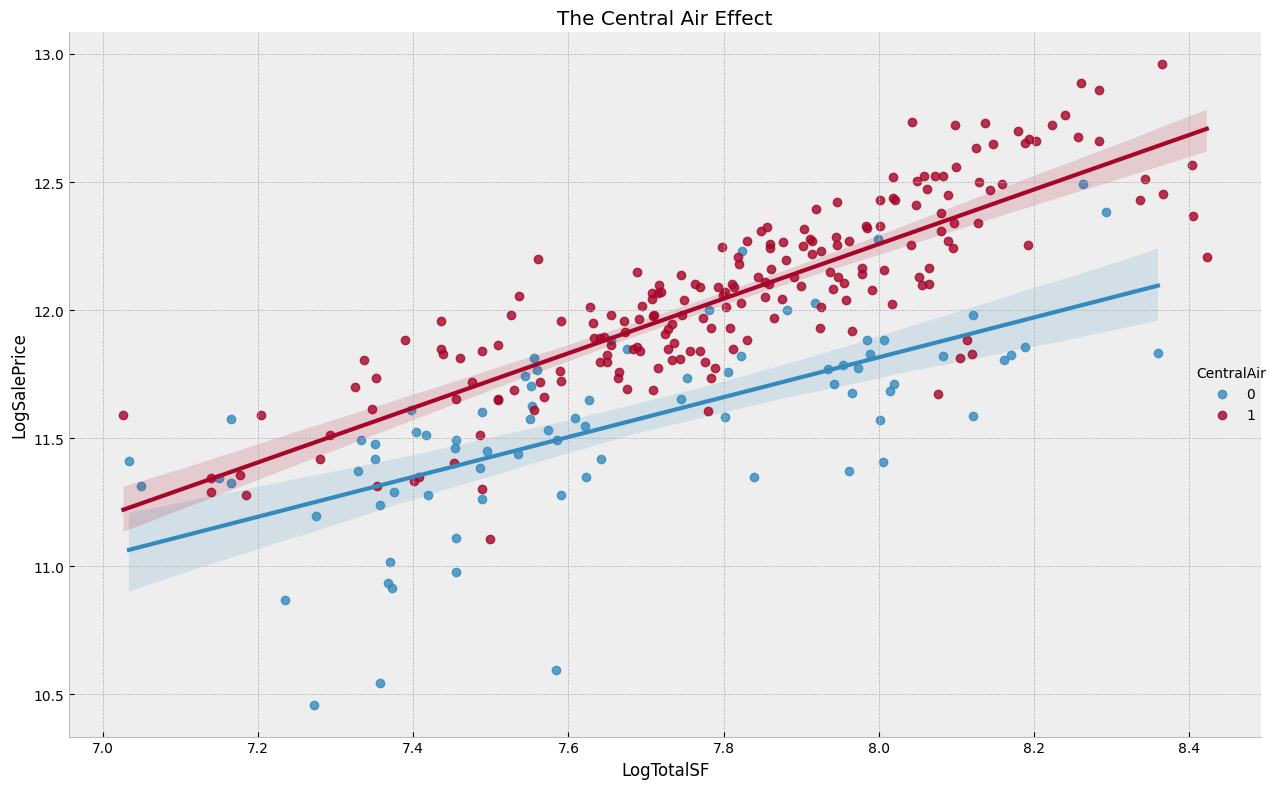

In [24]:
df_ca = df[['LogSalePrice','LogTotalSF','CentralAir']].assign(CentralAir = lambda df: (df['CentralAir'] == 'Y').astype(int)).copy()
df_ca = pd.concat([df_ca[df_ca['CentralAir'] == 0].copy(), df_ca[df_ca['CentralAir'] == 1].sample(200, random_state = 58)]).reset_index(drop=True).copy()
df_ca = df_ca.loc[df_ca['LogTotalSF'] > 7.0].reset_index().copy()
sns.lmplot(data = df_ca, x='LogTotalSF', y = 'LogSalePrice', hue = 'CentralAir', height = 8, aspect = 1.5)
plt.title('The Central Air Effect')
plt.tight_layout()

In our linear regression model represented by the equation $log(SalePrice_i) = \beta_0 + \beta_1*(log(TotalSF_i)) + \beta_2*CentralAir_i + \epsilon_i$, the coefficient $\beta_2$ represents the change in the log sale price associated with the presence of Central Air, holding all other variables constant.

The output of our Ordinary Least Squares (OLS) regression indicates that the coefficient on Central Air has a mean value of 0.3325. This suggests that, on average, a house with the same LogTotalSF but without Central Air would have a log sale price approximately 0.3325 lower than a comparable house with Central Air.

Since our linear model operates on the logarithm of the sale price, the effect of Central Air on the actual sale price becomes multiplicative. By exponentiating the calculated coefficient ($e^{0.3325}$), we find that, on average, having Central Air would increase the sale price by a factor of approximately 1.39 times.

In [25]:
model = smf.ols('LogSalePrice ~  CentralAir + LogTotalSF' ,data = df_ca).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:           LogSalePrice   R-squared:                       0.723
Model:                            OLS   Adj. R-squared:                  0.721
Method:                 Least Squares   F-statistic:                     362.2
Date:                Mon, 13 May 2024   Prob (F-statistic):           5.01e-78
Time:                        19:55:25   Log-Likelihood:                 22.107
No. Observations:                 280   AIC:                            -38.21
Df Residuals:                     277   BIC:                            -27.31
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      4.1539      0.360     11.550      0.0

### Mixed Effects Model 

Mixed Effects Models, often referred to as Hierarchical models, offer a powerful approach for analyzing data with a nested structure. They are particularly useful when exploring the relationship between variables across multiple levels of a categorical grouping. For the purpose of this analysis and concluding our Exploratory Data Analysis, we will employ Mixed Effects Models to examine how the relationship between LogSalesPrice and LogTotalSF varies across different neighborhoods. The overall trend is depicted in the grid of lmplots below.

The plot reveals that the relationship between LogSalePrice and LogTotalSF differs across neighborhoods in the dataset. For instance, houses in the Northridge Heights neighborhood exhibit a steeper increase in price with increasing square footage compared to those in the Mitchell neighborhood.

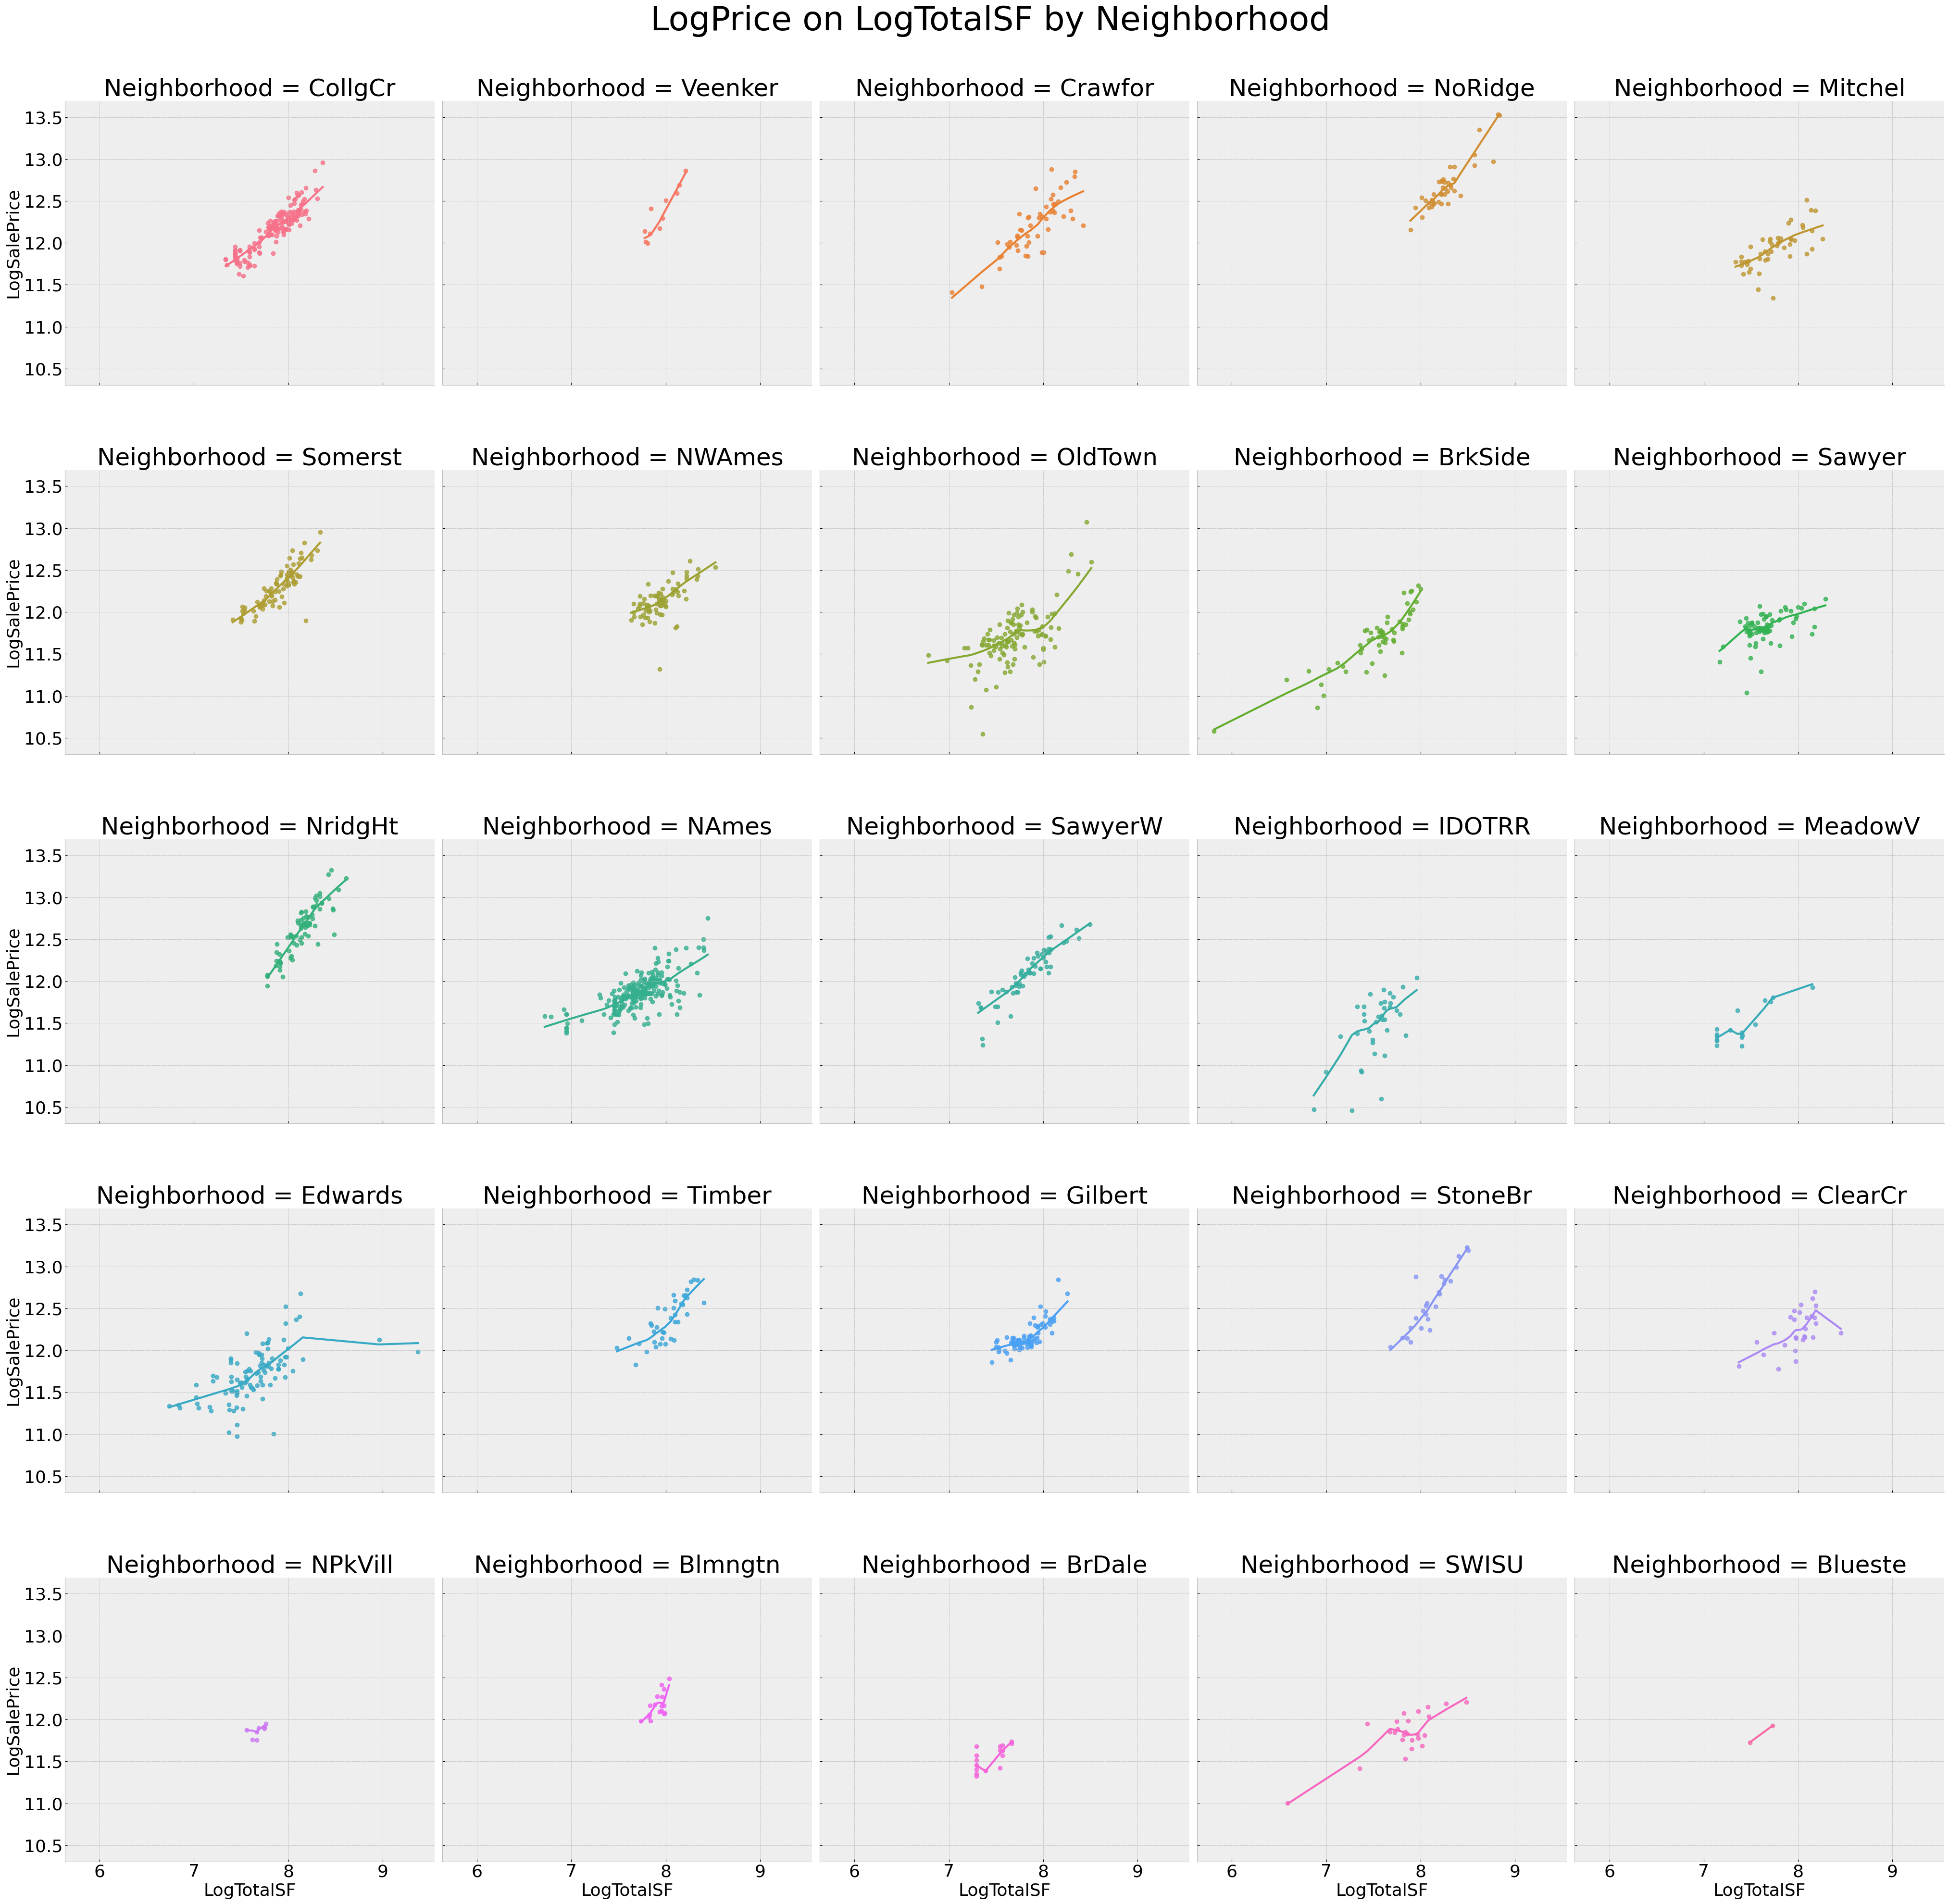

In [26]:
g = sns.lmplot(data=df,
               x='LogTotalSF',
               y='LogSalePrice',
               col='Neighborhood',
               col_wrap=5,
               hue='Neighborhood',
               height=8,
               aspect=1,
               lowess=True)


g.fig.subplots_adjust(top=0.93, hspace=0.3)  # Adjust 'hspace' for vertical spacing


g.fig.suptitle('LogPrice on LogTotalSF by Neighborhood', fontsize=50)

for ax in g.axes.flat:
    title = ax.get_title()
    ax.set_title(title, fontsize=36)  
    ax.set_ylabel('LogSalePrice', fontsize=26)  
    ax.set_xlabel('LogTotalSF', fontsize = 26)

    ax.tick_params(axis='y', labelsize=26)
    ax.tick_params(axis='x', labelsize=26)
plt.show()

### Random Slopes/Intercepts Model

Mixed Effects models typically incorporate two types of predictor variables: **Fixed** effects and **Random** effects. The Fixed effects capture the relationships of primary interest, while the Random effects account for variability at different levels of grouping within the data.

In our case, the Fixed effect is represented by LogTotalSF, indicating the primary variable of interest. The Random effect will be the Neighborhood variable, capturing the variability between different neighborhoods.

Mixed Effects models offer various specifications for incorporating Random effects, including Random intercepts, slopes, quadratic terms, and more. For our analysis based on the insights from our Exploratory Data Analysis (EDA), we will fit a Random Slopes and Intercepts model. This model allows both the intercepts and slopes to vary randomly across different neighborhoods, providing a nuanced understanding of how the relationship between LogSalePrice and LogTotalSF varies across neighborhoods.

Now, for the specification of the Random Slopes and Intercepts model:

$$LogSalePrice_{ij} \ = \ \beta_{0j} + \  \beta_{ij}*LogTotalSF_{ij} \ + \ \epsilon_{ij}$$ 

This model resembles the standard OLS regression model, with the addition of the j subscript. This subscript signifies adjustments made to the Fixed effects slope and intercept parameters for the entire dataset, specific to each neighborhood. In other words, the model allows for neighborhood-specific variations in both the intercept and slope of the relationship between LogTotalSF and LogSalePrice.

This model allows the intercept and slope of the LogTotalSF-LogSalePrice relationship to vary randomly across different neighborhoods, capturing the neighborhood-specific effects on the housing prices' relationship with square footage.

In [27]:
model_formula =  'LogSalePrice ~ LogTotalSF'
random_effects_formula = '1 + LogTotalSF'
mixed_model = sm.MixedLM.from_formula(model_formula, groups='Neighborhood', re_formula=random_effects_formula, data=df)
model_result = mixed_model.fit(method = 'nm',maxiter = 1000)
print(model_result.summary())

                 Mixed Linear Model Regression Results
Model:                  MixedLM     Dependent Variable:     LogSalePrice
No. Observations:       1460        Method:                 REML        
No. Groups:             25          Scale:                  0.0291      
Min. group size:        2           Log-Likelihood:         443.1576    
Max. group size:        225         Converged:              Yes         
Mean group size:        58.4                                            
------------------------------------------------------------------------
                              Coef.  Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------------------------
Intercept                      5.167    0.488 10.594 0.000  4.211  6.123
LogTotalSF                     0.875    0.064 13.579 0.000  0.749  1.002
Neighborhood Var               4.469    9.769                           
Neighborhood x LogTotalSF Cov -0.595    1.287                        

Using the ```MixedLM``` class from the ```statsmodels``` API, we fitted a random slopes and random intercepts model. The Fixed effect estimates for the LogTotalSF slope and intercept parameters are 0.875 and 5.167, respectively. The table below illustrates the adjustments to these parameters per neighborhood. For instance, in the first entry corresponding to the Bloomington Neighborhood, there is an adjustment to the intercept of -0.759945 and an adjustment to the slope of 0.104681.

Employing a Mixed Effects Model enhances flexibility when modeling the relationship between Salesprice and Squarefoot for each neighborhood. It offers insights into how the neighborhood influences the overall relationship observed between Price and Square Footage.

In [28]:
pd.DataFrame(model_result.random_effects).T.rename({'Neighborhood':'Intercept', 'LogTotalSF':'Slope'}, axis = 1)

,Intercept,Slope
Blmngtn,-0.759945,0.104681
Blueste,0.028399,-0.003862
BrDale,0.664538,-0.105357
BrkSide,0.608593,-0.090616
ClearCr,1.023893,-0.119426
CollgCr,-0.464180,0.074952
Crawfor,-0.477913,0.074456
Edwards,2.661203,-0.366398
Gilbert,0.861126,-0.091752
IDOTRR,-1.778157,0.198062


# Machine Learning Model Development

It's time for the Grand Finale of the notebook! After meticulously cleaning the data and conducting some sophisticated exploratory data analysis, we're now ready to embark on the journey of training and tuning a variety of fancy ML models, all in pursuit of securing our place at the top of the leaderboard.

As mentioned at the beginning of this notebook, our chosen method will be building a StackingRegressor model from scikit-learn. The concept behind the StackingRegressor is to fit individual regressors in the first round and then utilize the outputs of these models as inputs for a final regressor. Luckily, the scikit-learn ecosystem provides excellent functionality that seamlessly integrates this with the Pipeline paradigm, making visualization and understanding of the process a breeze.

For our initial models in Phase 1, we'll employ a **Lasso** Regression, a **LightGBM**, and an **XGBoost** regressor. The outputs of these models will then be fed into a linear regression model for that extra boost in performance. However, before fitting the stacking regressor, let's first find the ideal tuning parameters for each of our Phase 1 models.

In [29]:

predictor_cols = [
                  'MSSubClass', 
                  'MSZoning', 
                  'Street',
                  'Alley', 
                  'LotShape', 
                  'LandContour', 
                  'Utilities', 
                  'LotConfig',
                  'LandSlope', 
                  'Neighborhood',
                  'Condition1',
                  'Condition2', 
                  'BldgType',
                  'HouseStyle',
                  'OverallQual', 
                  'OverallCond', 
                  'YearBuilt', 
                  'YearRemodAdd',
                  'RoofStyle', 
                  'RoofMatl',
                  'Exterior1st', 
                  'Exterior2nd', 
                  'MasVnrType',
                  'MasVnrArea', 
                  'ExterQual', 
                  'ExterCond',
                  'Foundation',
                  'BsmtQual',
                  'BsmtCond', 
                  'BsmtExposure',
                  'BsmtFinType1',
                  'BsmtFinType2',
                  'Heating',
                  'HeatingQC',
                  'CentralAir',
                  'Electrical',
                  'LowQualFinSF',
                  'GrLivArea',
                  'BsmtFullBath',
                  'BsmtHalfBath',
                  'FullBath',
                  'HalfBath',
                  'BedroomAbvGr',
                  'KitchenAbvGr',
                  'KitchenQual',
                  'TotRmsAbvGrd',
                  'Functional',
                  'Fireplaces', 
                  'FireplaceQu',
                  'GarageType',
                  'GarageYrBlt',
                  'GarageFinish',
                  'GarageCars',
                  'GarageArea',
                  'GarageQual',
                  'GarageCond',
                  'PavedDrive',
                  'WoodDeckSF',
                  'OpenPorchSF',
                  'EnclosedPorch',
                  '3SsnPorch',
                  'ScreenPorch',
                  'PoolArea',
                  'Fence',
                  'MiscVal',
                  'MoSold', 
                  'YrSold', 
                  'SaleType',
                  'SaleCondition',
                  'TotalBath',
                  'YearsSinceRemod',
                  'TotalSFXLotArea',
                  'HousePerLotArea',
                  'SFPerRoom',
                  'LogTotalSF',
                  'LogLotArea',
                  'LogLotFrontage', 
                  'LogBsmtFinSF1', 
                  'LogBsmtFinSF2',
                  'LogBsmtUnfSF', 
                  'LogTotalBsmtSF',
                  'Shed', 
                  'LogWoodDeckSF',
                  'LogOpenPorchSF', 
                  'Log1stFlrSF', 
                  'Log2ndFlrSF', 
                  'LogMasVnrArea',
                  'LogLowQualFinSF', 
                  'LogGrLivArea',
                  'LogGarageArea',
                  'LogPoolArea'
                 ]

response_col = ['LogSalePrice']

### Create Test and Train Modeling Data


In [30]:
X_train,y_train = df[predictor_cols], df[response_col].values.reshape(df.shape[0],)
X_test = df_test[predictor_cols]

### Tree Preprocessing

The following steps use ```make_column_selector```, ```OrdinalEncoder```, and ```make_column_transformer``` to create the preproccesing pipeline for our tree based models. (XGBoost and LGBM)



In [31]:
# creates a feature selector to pull only object dtypes
cat_feature_selector = make_column_selector(dtype_include = object)
# creates a feature selector to pull only numeric dtypes
num_feature_selector = make_column_selector(dtype_include = np.number)

# Creates a processer to turn object columns into an ordinal feature
cat_tree_processor = OrdinalEncoder(
    handle_unknown="use_encoded_value",
    unknown_value=-1,
    encoded_missing_value=-2,
)

# Creates a SimpleImputer for Numerical columns
num_tree_processor = SimpleImputer(strategy="mean")

# Make Tree Preprocessor
tree_preprocessor = make_column_transformer(
    (num_tree_processor, num_feature_selector), (cat_tree_processor, cat_feature_selector),remainder='passthrough'
)


### LGBM Tuning

Below we use ```GridSearchCV``` to conduct a search for the optimal hyperparameters. The method chosen was that of a Full Factorial Design like structure with each factor having 2 levels. The parameters that yield the best **MSE** were then chosen for the model.

In [32]:
lgbm_model = lgb.LGBMRegressor(verbose = -1)

lgbm_pipeline = make_pipeline(tree_preprocessor, lgbm_model)

param_grid = {
    'lgbmregressor__max_depth': [3, 15],
    'lgbmregressor__n_estimators': [100, 800],
    'lgbmregressor__learning_rate' : [0.035, 0.8],
    'lgbmregressor__reg_alpha': [0.001, 0.5]
}

grid_search = GridSearchCV(estimator=lgbm_pipeline, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', verbose=1)


grid_search.fit(X_train, y_train)

# Best parameters and best score
print("Best parameters:", grid_search.best_params_)
print("Best score (RMSE):", (-grid_search.best_score_)**0.5)

# Using the best estimator
best_model = grid_search.best_estimator_
predictions = best_model.predict(X_train)
rmse = mean_squared_error(y_train, predictions, squared=False)
print("Test RMSE:", rmse)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best parameters: {'lgbmregressor__learning_rate': 0.035, 'lgbmregressor__max_depth': 3, 'lgbmregressor__n_estimators': 800, 'lgbmregressor__reg_alpha': 0.001}
Best score (RMSE): 0.12831575759263653
Test RMSE: 0.06994226012291914


In [33]:
cv_results = grid_search.cv_results_

results_df = pd.DataFrame(cv_results)

print(results_df[['param_lgbmregressor__max_depth', 'param_lgbmregressor__n_estimators', 'param_lgbmregressor__learning_rate', 'mean_test_score', 'std_test_score']])


   param_lgbmregressor__max_depth param_lgbmregressor__n_estimators  \
0                               3                               100   
1                               3                               100   
2                               3                               800   
3                               3                               800   
4                              15                               100   
5                              15                               100   
6                              15                               800   
7                              15                               800   
8                               3                               100   
9                               3                               100   
10                              3                               800   
11                              3                               800   
12                             15                               100   
13    

### XGB Tuning

The exact same approach was taken for the **XGBoost** model as used with the **LGBM**

In [34]:
xgb_model = xgb.XGBRegressor(objective='reg:squarederror')

xgb_pipeline = make_pipeline(tree_preprocessor, xgb_model)

param_grid = {
    'xgbregressor__max_depth': [3, 8],
    'xgbregressor__n_estimators': [150, 500],
    'xgbregressor__learning_rate' : [0.035, 0.25],
    'xgbregressor__reg_alpha': [0.001, 0.5]
}

grid_search = GridSearchCV(estimator=xgb_pipeline, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', verbose=1)


grid_search.fit(X_train, y_train)

# Best parameters and best score
print("Best parameters:", grid_search.best_params_)
print("Best score (RMSE):", (-grid_search.best_score_)**0.5)

# Using the best estimator
best_model = grid_search.best_estimator_
predictions = best_model.predict(X_train)
rmse = mean_squared_error(y_train, predictions, squared=False)
print("Test RMSE:", rmse)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best parameters: {'xgbregressor__learning_rate': 0.035, 'xgbregressor__max_depth': 3, 'xgbregressor__n_estimators': 500, 'xgbregressor__reg_alpha': 0.001}
Best score (RMSE): 0.12460919186954439
Test RMSE: 0.0698750977539734


In [35]:
cv_results = grid_search.cv_results_
results_df = pd.DataFrame(cv_results)
print(results_df[['param_xgbregressor__max_depth', 'param_xgbregressor__n_estimators', 'param_xgbregressor__learning_rate', 'mean_test_score', 'std_test_score']])

   param_xgbregressor__max_depth param_xgbregressor__n_estimators  \
0                              3                              150   
1                              3                              150   
2                              3                              500   
3                              3                              500   
4                              8                              150   
5                              8                              150   
6                              8                              500   
7                              8                              500   
8                              3                              150   
9                              3                              150   
10                             3                              500   
11                             3                              500   
12                             8                              150   
13                             8  

### Linear Preprocessing

In the next step the preprocessing pipeline is built for the Lasso Regression model. There is a slight adjustment made for the linear model in how categorical values are being handled.

In [36]:
# Create One Hot Encoder Instance
cat_linear_processor = OneHotEncoder(handle_unknown='infrequent_if_exist')

# Create Simple imputer instance 
num_linear_processor = make_pipeline(
    StandardScaler() ,SimpleImputer(strategy="mean")
)

# Create Column Transformer
linear_preprocessor = make_column_transformer(
    (num_linear_processor, num_feature_selector), (cat_linear_processor, cat_feature_selector), remainder='passthrough'
)


linear_preprocessor

ColumnTransformer(remainder='passthrough',
                  transformers=[('pipeline',
                                 Pipeline(steps=[('standardscaler',
                                                  StandardScaler()),
                                                 ('simpleimputer',
                                                  SimpleImputer())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7c0fe037ed40>),
                                ('onehotencoder',
                                 OneHotEncoder(handle_unknown='infrequent_if_exist'),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7c0fe037f3a0>)])

### Grid Search Lasso

When performing gridsearch on the Lasso, the only parameter tuned was the L1 penalty

In [37]:
lasso_pipeline = make_pipeline(linear_preprocessor, Lasso())
param_grid = {
    'lasso__alpha': [0.01,0.001,0.1,0.005],
}

grid_search = GridSearchCV(estimator=lasso_pipeline, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', verbose=1)

grid_search.fit(X_train, y_train)

print("Best parameters:", grid_search.best_params_)
print("Best score (RMSE):", (-grid_search.best_score_)**0.5)

best_model = grid_search.best_estimator_
predictions = best_model.predict(X_train)
rmse = mean_squared_error(y_train, predictions, squared=False)
print("Test RMSE:", rmse)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
Best parameters: {'lasso__alpha': 0.001}
Best score (RMSE): 0.12767854244134555
Test RMSE: 0.11135827284805644


### Build Model Stacker

Now the final step in building the **StackingRegressor** model is to take all of the pipelines and hyperparameters and instatiate the ```stacking_regressor``` object. Once set, sklearn provides a great visual of the pipeline just by calling the stacking_regressor object. This will show exactly what is going on. Notice that I used all of the optimal paramters for our hyperparameter tuning previously. 


**Note** 
Much of the code to make this pipeline can be found in a great example made by the scikit-learn folks and can be found here.   
[Stacking Regressors with the scikit-learn Example](https://scikit-learn.org/stable/auto_examples/ensemble/plot_stack_predictors.html#sphx-glr-auto-examples-ensemble-plot-stack-predictors-py)


In [38]:
xgb_pipeline = make_pipeline(tree_preprocessor, xgb.XGBRegressor(objective='reg:squarederror',learning_rate = 0.035, n_estimators = 500, max_depth = 3, reg_alpha = 0.001))
lasso_pipeline = make_pipeline(linear_preprocessor,Lasso(alpha = 0.001))
lgbm_pipeline = make_pipeline(tree_preprocessor, lgb.LGBMRegressor(verbose = -1,learning_rate = 0.035, n_estimators = 800, max_depth = 3,reg_alpha=0.001))

estimators = [
   ("Lasso", lasso_pipeline),
   ("LGBM", lgbm_pipeline),
    ("XGB" ,xgb_pipeline),
]


stacking_regressor = StackingRegressor(estimators=estimators, final_estimator=LinearRegression(),cv=10, passthrough = False)
stacking_regressor

StackingRegressor(cv=10,
                  estimators=[('Lasso',
                               Pipeline(steps=[('columntransformer',
                                                ColumnTransformer(remainder='passthrough',
                                                                  transformers=[('pipeline',
                                                                                 Pipeline(steps=[('standardscaler',
                                                                                                  StandardScaler()),
                                                                                                 ('simpleimputer',
                                                                                                  SimpleImputer())]),
                                                                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7c0fe037ed40>),
                                                                                ('onehotencoder',
                                                                                 OneHotEncoder...
                                                             interaction_constraints=None,
                                                             learning_rate=0.035,
                                                             max_bin=None,
                                                             max_cat_threshold=None,
                                                             max_cat_to_onehot=None,
                                                             max_delta_step=None,
                                                             max_depth=3,
                                                             max_leaves=None,
                                                             min_child_weight=None,
                                                             missing=nan,
                                                             monotone_constraints=None,
                                                             multi_strategy=None,
                                                             n_estimators=500,
                                                             n_jobs=None,
                                                             num_parallel_tree=None,
                                                             random_state=None, ...))]))],
                  final_estimator=LinearRegression())

In the code below we can use some of the SK-learn functionality to see the results of our 10 fold CV approach on the original training dataset.

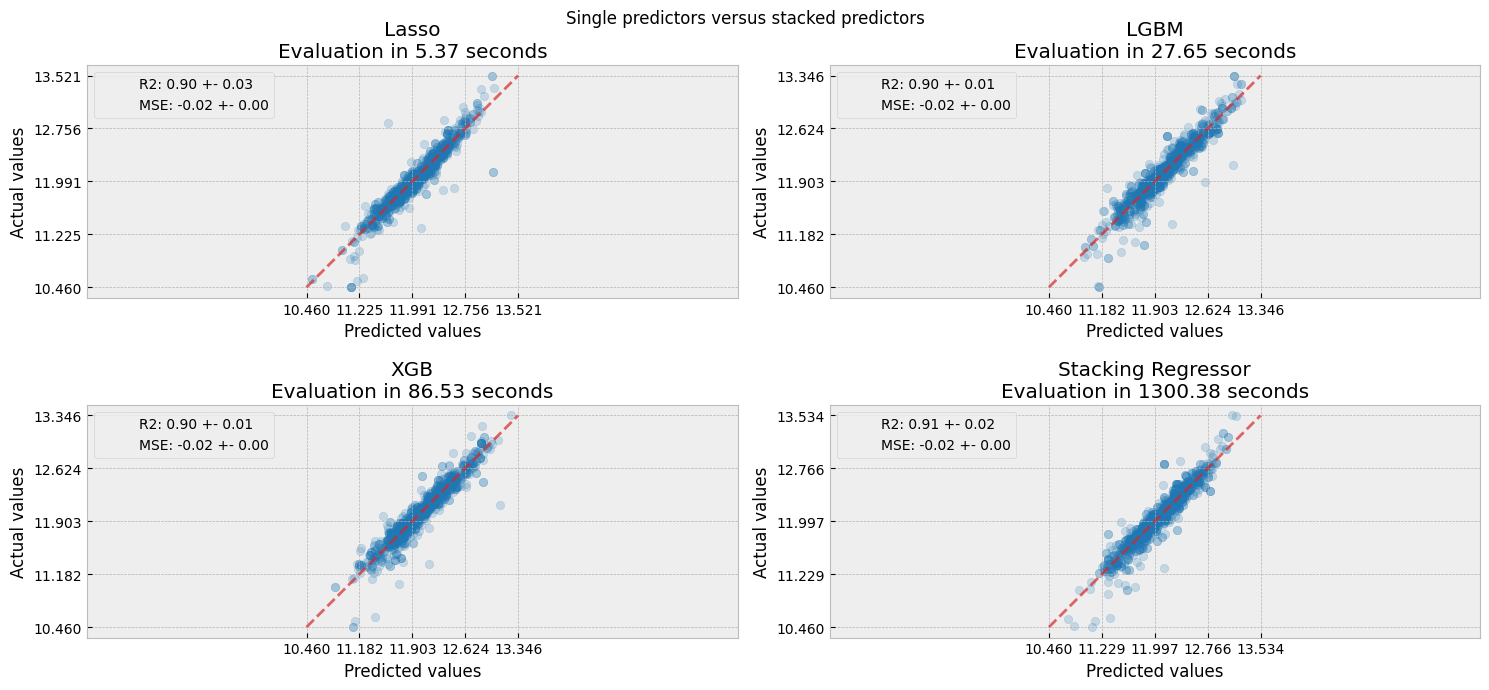

In [39]:
import time

import matplotlib.pyplot as plt

from sklearn.metrics import PredictionErrorDisplay
from sklearn.model_selection import cross_val_predict, cross_validate

fig, axs = plt.subplots(2, 2, figsize=(15, 7))
axs = np.ravel(axs)

for ax, (name, est) in zip(
    axs, estimators + [("Stacking Regressor", stacking_regressor)]
):
    scorers = {"R2": "r2", "MSE": "neg_mean_squared_error"}

    start_time = time.time()
    scores = cross_validate(
        est, X_train, y_train, scoring=list(scorers.values()), n_jobs=-1, verbose=0
    )
    elapsed_time = time.time() - start_time

    y_pred = cross_val_predict(est, X_train, y_train, n_jobs=-1, verbose=0)
    scores = {
        key: (
            f"{np.mean(scores[f'test_{value}']):.2f} +- "
            f"{np.std(scores[f'test_{value}']):.2f}"
        )
        for key, value in scorers.items()
    }

    display = PredictionErrorDisplay.from_predictions(
        y_true=y_train,
        y_pred=y_pred,
        kind="actual_vs_predicted",
        ax=ax,
        scatter_kwargs={"alpha": 0.2, "color": "tab:blue"},
        line_kwargs={"color": "tab:red"},
    )
    ax.set_title(f"{name}\nEvaluation in {elapsed_time:.2f} seconds")

    for name, score in scores.items():
        ax.plot([], [], " ", label=f"{name}: {score}")
    ax.legend(loc="upper left")

plt.suptitle("Single predictors versus stacked predictors")
plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()

Finally we create our predictions and submit our score! This approach got me a score on the test data of about 0.118 which at the time of creating this notebook was about **120/4800**.

### Create Predictions

In [40]:
X_test = df_test[predictor_cols] 
fit_stack = stacking_regressor.fit(X_train,y_train)
predictions = np.exp(stacking_regressor.predict(X_test))
submission_df = pd.DataFrame({'Id': df_test['Id'],'SalePrice' : predictions})
submission_df.to_csv('submission.csv',index=False)


And there you have it, folks! We've journeyed through the depths of the Ames Iowa housing dataset, armed with nothing but our wits and Python prowess. From unraveling the mysteries of basic and advanced EDA to crafting sophisticated mixed effects models, we've left no stone unturned in our quest for predictive excellence. Armed with our finely-tuned stacking regression model we were able to rock an amazing score on the test dataset. I hope you have enjoyed this data jam out and thanks for coming along on the ride with me!